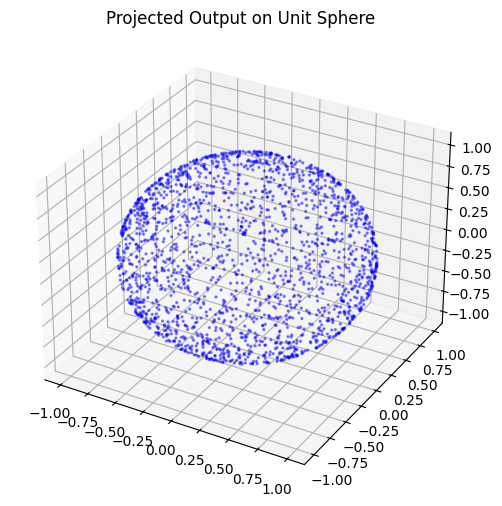

Gradient for net.0.weight: mean=-0.000894, std=0.018444
Gradient for net.0.bias: mean=-0.001189, std=0.013076
Gradient for net.2.weight: mean=-0.001939, std=0.021565
Gradient for net.2.bias: mean=-0.007428, std=0.040490
Gradient for net.4.weight: mean=-0.016196, std=0.057433
Gradient for net.4.bias: mean=-0.048686, std=0.247065
Epoch 0: Train Loss = 0.7470, Val Loss = 0.7236
Gradient for net.0.weight: mean=-0.000955, std=0.018483
Gradient for net.0.bias: mean=-0.001666, std=0.012957
Gradient for net.2.weight: mean=-0.002117, std=0.021264
Gradient for net.2.bias: mean=-0.008065, std=0.039760
Gradient for net.4.weight: mean=-0.014689, std=0.056842
Gradient for net.4.bias: mean=-0.035890, std=0.239097
Gradient for net.0.weight: mean=-0.000938, std=0.018605
Gradient for net.0.bias: mean=-0.002036, std=0.012940
Gradient for net.2.weight: mean=-0.002360, std=0.021039
Gradient for net.2.bias: mean=-0.009009, std=0.039279
Gradient for net.4.weight: mean=-0.013212, std=0.056289
Gradient for net

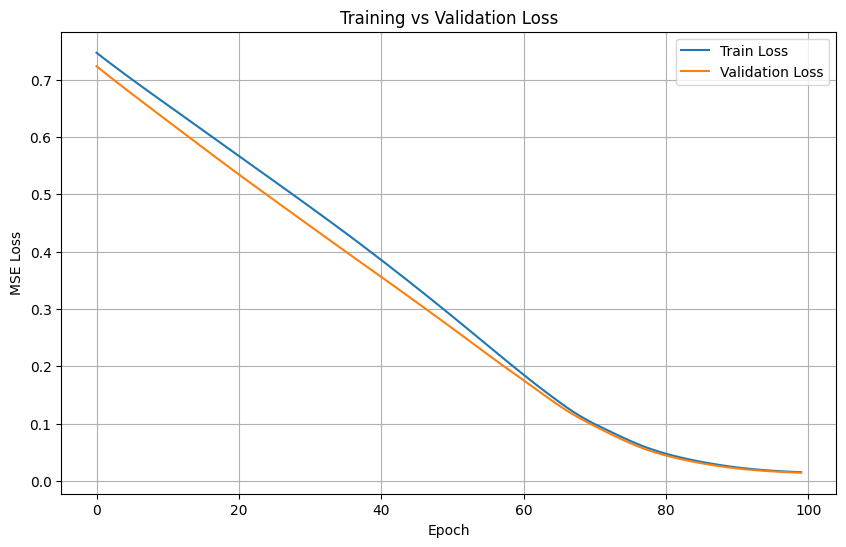

Test MSE Loss: 0.0139
Mean Cosine Similarity: 0.9792


In [16]:
# 1. Imports and Setup

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seed
torch.manual_seed(42)
np.random.seed(42)


# 2. Generate 3D Gaussian Data & Project to Unit Sphere

def generate_3d_normal_data(n_samples: int = 2000):
    x = np.random.randn(n_samples, 3)  # Standard normal
    y = x / np.linalg.norm(x, axis=1, keepdims=True)  # Project onto unit sphere
    return x, y

x, y = generate_3d_normal_data()

# Visualize unit sphere projection
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c='blue', s=2, alpha=0.4)
ax.set_title("Projected Output on Unit Sphere")
plt.show()


# 3. Split Data

x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2)

# Convert to PyTorch tensors
def to_tensor(arr): return torch.tensor(arr, dtype=torch.float32)
x_train = to_tensor(x_train)
y_train = to_tensor(y_train)
x_val = to_tensor(x_val)
y_val = to_tensor(y_val)
x_test = to_tensor(x_test)
y_test = to_tensor(y_test)


# 4. Define Neural Network

class SphereProjector(nn.Module):
    def __init__(self):
        super(SphereProjector, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features = 3, out_features= 20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features= 20),
            nn.ReLU(),
            nn.Linear(in_features= 20, out_features= 3)
        )

    def forward(self, x):
        output = self.net(x)
        # Normalize to unit sphere
        return output / torch.norm(output, dim=1, keepdim=True)

model = SphereProjector()


# 5. Train Model

loss_fn = nn.MSELoss()  # Changed from CrossEntropyLoss to MSELoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    # Show explicit gradients
    if epoch < 3:
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for {name}: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")

    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_pred = model(x_val)
        val_loss = loss_fn(val_pred, y_val)
        val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")


# 6. Plot Training vs Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# 7. Evaluate on Test Set

model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    test_loss = loss_fn(y_test_pred, y_test).item()

    # Cosine similarity as performance measure
    cosine_sim = nn.functional.cosine_similarity(y_test_pred, y_test, dim=1).mean().item()
    print(f"Test MSE Loss: {test_loss:.4f}")
    print(f"Mean Cosine Similarity: {cosine_sim:.4f}")

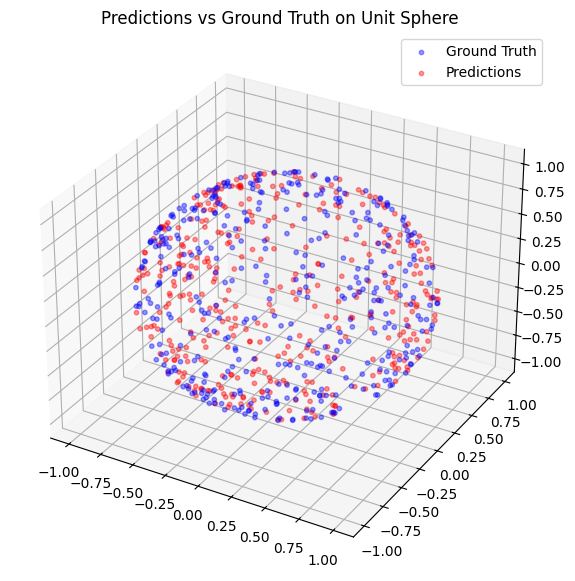

In [14]:

#  Visualize Predictions vs Ground Truth on Unit Sphere

from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

# Convert tensors to numpy
y_true_np = y_test.numpy()
y_pred_np = y_test_pred.numpy()

# Create 3D scatter plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot ground truth in blue
ax.scatter(y_true_np[:, 0], y_true_np[:, 1], y_true_np[:, 2], c='blue', s=10, alpha=0.4, label='Ground Truth')

# Plot predictions in red
ax.scatter(y_pred_np[:, 0], y_pred_np[:, 1], y_pred_np[:, 2], c='red', s=10, alpha=0.4, label='Predictions')

ax.set_title("Predictions vs Ground Truth on Unit Sphere")
ax.legend()
plt.show()
